
# Baseline Empirical Distribution of Accrual of Guarantee


- accepts a path (or matrix) of monthly **Active Asset returns** \(A_t\), and
- accepts a corresponding path (or matrix) of **rolling zero-coupon bond prices** \(P_t\),
and then performs the tie-in logic and computes the **empirical distribution of the accrual of guarantee**.

You can run the synthetic demo below immediately, and later replace it with your real data.


In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

# Notebook display prefs (optional)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")



# We define parameters and calculate our outcome for single tie in path given active portfolio return and zcb prices

In [16]:

@dataclass
# Define parameters for the tie-in strategy
class TieInConfig:
    initial_wealth: float = 100.0
    L_target: float = 1.25   
    L_trigger: float = 1.30


@dataclass
# Zero coupon bond parameters
class PathResult:
    final_N: float
    initial_N: float
    # two different ways to measure accrual
    accrual_abs: float
    accrual_pct: float
    history: pd.DataFrame


# Simulate a single path of the tie-in strategy
# Important to note cfg is not needed
def simulate_tie_in_path(
    active_returns: np.ndarray,     # has dimension (T) (monthly discrete returns of Active)
    zcb_prices: np.ndarray,         # starts at 0 so has dimension (T+1) (rolling ZCB prices, including month 0 and maturity)
    cfg: TieInConfig | None = None, # if we want to change parameters in TieInFonfig we can: simulate_tie_in_path(active, zcb, TieInConfig(L_target=1.20))
) -> pd.DataFrame:
    if cfg is None:
        cfg = TieInConfig()
    
    T = len(active_returns)
    assert len(zcb_prices) == T + 1, "zcb_prices must have length T+1 (including month 0 and maturity)."

    W0 = cfg.initial_wealth
    MV_R = W0 / cfg.L_target                  # start exactly at target funded ratio
    MV_A = W0 - MV_R                          # Rest in active
    N = MV_R / zcb_prices[0]                  # initial face (units of the ZCB)

    rows = []
    rows.append(dict(month=0, MV_A=MV_A, MV_R=MV_R, N=N, P=zcb_prices[0], W=MV_A+MV_R,
                     L=(MV_A+MV_R)/MV_R, tie_in=False))
    
    # Do the calculations month by month
    for i in range(1, T+1):
        # 1) Active evolves
        MV_A = MV_A * (1.0 + active_returns[i-1])
        # 2) Reserve repriced from rolling ZCB
        P_i = zcb_prices[i]
        MV_R = N * P_i
        # Total wealth
        W = MV_A + MV_R
        # 3) Compute funded ratio
        L = W / MV_R if MV_R > 0 else float("inf")

        # We set tie in to false by default, but tie in if we are above our trigger
        tie_in = False
        if L > cfg.L_trigger:
            # Reset to target: W = L_target * N_new * P_i
            N_new = W / (cfg.L_target * P_i)       # new face (units of the ZCB)
            # new reserve and active
            MV_R = N_new * P_i
            MV_A = W - MV_R
            N = N_new
            tie_in = True

        rows.append(dict(month=i, MV_A=MV_A, MV_R=MV_R, N=N, P=P_i, W=MV_A+MV_R, L=(MV_A+MV_R)/MV_R, tie_in=tie_in))

    history = pd.DataFrame(rows, columns=['month','MV_A','MV_R','N','P','W','L','tie_in'])
    return history



## Rolling empirical distribution (many cohorts)
Provide matrices with shapes:
- `active_returns_matrix`: \((n\_starts, T)\)
- `zcb_price_matrix`: \((n\_starts, T+1)\)


In [17]:

def rolling_tie_in_distribution(
    active_returns_matrix: np.ndarray,  # (n_starts, T)
    zcb_price_matrix: np.ndarray,       # (n_starts, T+1)
    cfg: TieInConfig | None = None
): 
    if cfg is None:
        cfg = TieInConfig()
    
    n_starts, T = active_returns_matrix.shape
    assert zcb_price_matrix.shape == (n_starts, T+1), "zcb_price_matrix must be (n_starts, T+1)."

    records = []
    panel_frames = []

    for s in range(n_starts):
        hist = simulate_tie_in_path(active_returns_matrix[s], zcb_price_matrix[s], cfg)
        hist_ins = hist.copy()
        hist_ins.insert(0, 'start', s)
        panel_frames.append(hist_ins)

        initial_N = float(hist.loc[hist['month'].idxmin(), 'N'])
        final_N   = float(hist.loc[hist['month'].idxmax(), 'N'])
        records.append({
            'start': s,
            'initial_N': initial_N,
            'final_N': final_N,
            'accrual_abs': final_N - initial_N,
            'accrual_pct': final_N / initial_N - 1.0
        })
    
    summary = pd.DataFrame.from_records(records)
    panel = pd.concat(panel_frames, ignore_index=True)
    return summary, panel



## Demo (synthetic data you can run immediately)
This section just generates fake returns and a simple rolling ZCB price path so you can see outputs end-to-end.
Replace this later with your real `A_t` and `P_t` matrices.


In [18]:

# --- Synthetic data for a 10-year horizon (120 monthly steps) ---
np.random.seed(7)
T = 120
n_starts = 60

# Active returns: ~0.6%/mo mean, 4%/mo vol (illustrative only)
mu, sigma = 0.006, 0.04
active_returns_matrix = np.random.normal(mu, sigma, size=(n_starts, T))

# Rolling ZCB prices from a flat curve (illustrative): y = 2% (continuously compounded)
months = np.arange(T+1)
ttm_years = (T - months) / 12.0
y = 0.02
base_prices = np.exp(-ttm_years * y)
zcb_price_matrix = np.vstack([base_prices * np.exp(0.0005*np.random.randn(T+1)) for _ in range(n_starts)])

# Run
summary, panel = rolling_tie_in_distribution(active_returns_matrix, zcb_price_matrix)
summary.head()


,start,initial_N,final_N,accrual_abs,accrual_pct
0,0,97.720129,107.100532,9.380403,0.095993
1,1,97.706270,97.706270,0.000000,0.000000
2,2,97.701998,102.136375,4.434376,0.045387
3,3,97.707923,97.707923,0.000000,0.000000
4,4,97.827034,107.114818,9.287785,0.094941


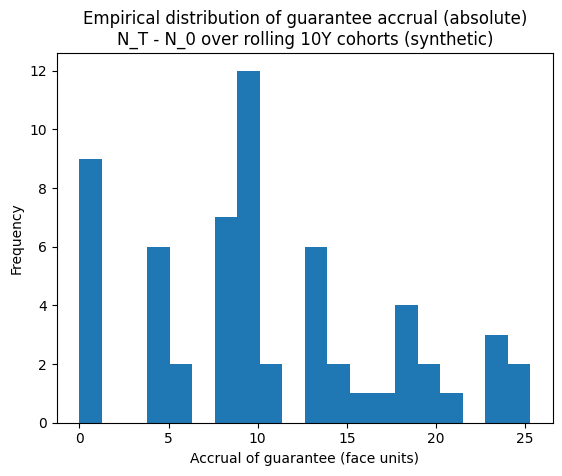

In [19]:

# Plot the empirical distribution of the accrual of guarantee (absolute)
plt.figure()
plt.hist(summary["accrual_abs"], bins=20)
plt.title("Empirical distribution of guarantee accrual (absolute)\nN_T - N_0 over rolling 10Y cohorts (synthetic)")
plt.xlabel("Accrual of guarantee (face units)")
plt.ylabel("Frequency")
plt.show()


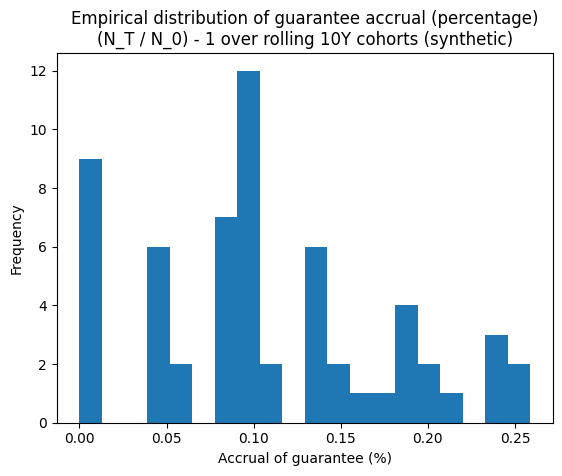

In [20]:

# Plot the empirical distribution of the accrual of guarantee (percentage)
plt.figure()
plt.hist(summary["accrual_pct"], bins=20)
plt.title("Empirical distribution of guarantee accrual (percentage)\n(N_T / N_0) - 1 over rolling 10Y cohorts (synthetic)")
plt.xlabel("Accrual of guarantee (%)")
plt.ylabel("Frequency")
plt.show()


### How to use with your real data
- Build `active_returns_matrix` with shape `(n_starts, 120)` from your chosen Active series.
- Build `zcb_price_matrix` with shape `(n_starts, 121)` for rolling ZCB prices.
- Then call:
```python
summary, panel = rolling_tie_in_distribution_matrix(active_returns_matrix, zcb_price_matrix)
```
`panel` is a stacked month-by-month matrix across all cohorts (with a `start` column).  
`summary` is one row per cohort with accrual statistics.
